In [1628]:
import qiskit
import qiskit_ibm_runtime
import numpy as np
from numpy import pi


from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit import Parameter

In [1630]:
service = QiskitRuntimeService.save_account(token, instance="*", overwrite="True")

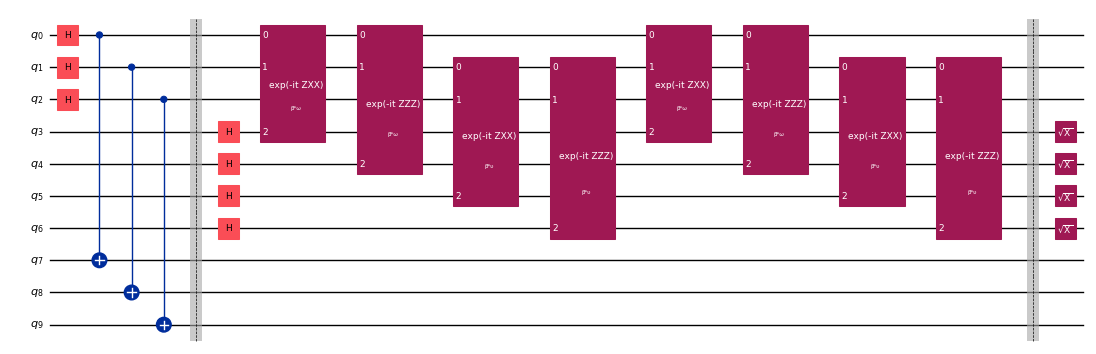

In [1702]:
ω = Parameter('ω')
ν = Parameter('υ')
β = Parameter('β')

X = SparsePauliOp("X")
Z = SparsePauliOp("Z")

qc_sym = QuantumCircuit(10)

qc_sym.h([0,1,2])
qc_sym.cx(0,7)
qc_sym.cx(1,8)
qc_sym.cx(2,9)
qc_sym.barrier()

ZXXω = PauliEvolutionGate(Z^X^X, time=β*ω)
ZZZω = PauliEvolutionGate(Z^Z^Z, time=β*ω)

ZXXν = PauliEvolutionGate(Z^X^X, time=β*ν)
ZZZν = PauliEvolutionGate(Z^Z^Z, time=β*ν)

qc_sym.h([3,4,5,6])

qc_sym.append(ZXXω,[0,1,3])
qc_sym.append(ZZZω,[0,1,4])

qc_sym.append(ZXXν,[1,2,5])
qc_sym.append(ZZZν,[1,2,6])

qc_sym.append(ZXXω,[0,1,3])
qc_sym.append(ZZZω,[0,1,4])

qc_sym.append(ZXXν,[1,2,5])
qc_sym.append(ZZZν,[1,2,6])

qc_sym.barrier()

qc_sym.sx([3,4,5,6])

qc_sym.draw("mpl",scale=0.5,fold=1000)

In [1690]:
sim = AerSimulator(method="statevector")

In [1756]:
H_sym = SparsePauliOp(["IIIIIZIIZZ","IIIIIIZIXX","IIIZIIIZZI","IIIIZIIXXI"], coeffs=[ω,ω,ν,ν])

In [1758]:
H = H_sym.assign_parameters({ω:pi/4,ν:pi/4})
H = SparsePauliOp(H.paulis, coeffs=np.asarray(H.coeffs, dtype=np.complex128)) #Forcing correct assignment

qc = qc_sym.assign_parameters({ω:pi/4,ν:pi/4,β:-0.45})

In [1760]:
pm = generate_preset_pass_manager(backend=sim, optimization_level=3)
isa_qc = pm.run(qc)
isa_H = H.apply_layout(isa_qc.layout)

In [1762]:
estimator = Estimator(mode=sim, options={"default_shots": 10000})

In [1764]:
res = estimator.run([(isa_qc, isa_H)]).result()[0]
print(f"Expectation values: {res.data.evs}")

Expectation values: -1.9630241695955823
